# Plotting all your GPS data from Google Takeout with Python

This is a simple notebook inspired on a few other articles online, such as [this one](http://beneathdata.com/how-to/visualizing-my-location-history/). However, I found those articles to be, typically, overcomplicated. I attempted to simplify them and get a simple map of your travels.

For this, I will be using `pandas`, `pyplot` and `Basemap`. `numpy` will be used in just a small area. My Anaconda installation didn't come with `Basemap`, so I installed it with `conda install basemap`. Next, I had a problem importing it, stating `KeyError: 'PROJ_LIB'`. That was solved by some googling, and adding an environment variable pointing to the file `epsg` 

In [136]:
import pandas as pd
import json
import os
os.environ["PROJ_LIB"] = r"C:\Users\Karl\Anaconda3\Library\share"
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

## Getting the data

Now that the modules are imported, you will need your location history file. This can be obtained from 
https://takeout.google.com/?pli=1. You can untick all files and select solely the location history. Mine was somewhat big, 166 MB uncompressed, and it took less than 5 minutes to get ready. Extract the `.json` file into the same folder as this notebook.


## Loading the data

A `.json` file is a very common type of text file format used extensively in the communication between web services. It can also be used to transfer tabular data, but it is sometimes a bit wordy. To load the file, use the method `loads` (load string) from the `json` library. It will translate the text file into dictionaries and lists. To visualize it, I will use the module `pretty print`.

In [181]:
with open('locationhistory.json', 'r') as fh:
    raw = json.loads(fh.read())

import pprint
pprint.pprint(raw['locations'][0:3])
print(len(raw['locations']))

[{'accuracy': 16,
  'activity': [{'activity': [{'confidence': 100, 'type': 'STILL'}],
                'timestampMs': '1552567462890'}],
  'latitudeE7': -230706413,
  'longitudeE7': -469493862,
  'timestampMs': '1552567402627'},
 {'accuracy': 31,
  'activity': [{'activity': [{'confidence': 100, 'type': 'STILL'}],
                'timestampMs': '1552567282375'}],
  'latitudeE7': -230706477,
  'longitudeE7': -469491360,
  'timestampMs': '1552567282246'},
 {'accuracy': 31,
  'latitudeE7': -230706474,
  'longitudeE7': -469491388,
  'timestampMs': '1552567221258'}]
471753


`raw` is a dictionary with only on key, `'locations'`. The corresponding value of this key is a (typically) very long list. Each element of this list, in turn, is a dictionary with a few keys, `accuracy`, `activity`, `latitudeE7`, `longitudeE7` and `timestampsMs`. For this project, we will use solely the latitude and longitude.

Thankfully, pandas can easily read our raw file. That will be stored in a dataframe.

In [182]:
df = pd.DataFrame(raw['locations'])
df.head()

,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy
0,16,"[{'timestampMs': '1552567462890', 'activity': ...",NaN,NaN,-230706413,-469493862,1552567402627,NaN,NaN
1,31,"[{'timestampMs': '1552567282375', 'activity': ...",NaN,NaN,-230706477,-469491360,1552567282246,NaN,NaN
2,31,NaN,NaN,NaN,-230706474,-469491388,1552567221258,NaN,NaN
3,33,NaN,NaN,NaN,-230706490,-469493788,1552567115729,NaN,NaN
4,15,"[{'timestampMs': '1552567099064', 'activity': ...",NaN,NaN,-230706415,-469493857,1552567098972,NaN,NaN


As can be seen, the `activity` key is a list, and pandas didn't bother to normalize it. I tried to get it out, and had little luck using `json_normalize` from `pd.io.json`. In this case, I brewed my own solution. It is in the end of this document, so as not to disturb the flow.

We can now delete the raw data to save some memory, and convert the column names into something better

In [183]:
del raw

df['latitudeE7'] = df['latitudeE7'] / 1E7
df['longitudeE7'] = df['longitudeE7'] / 1E7
df.rename(columns={'latitudeE7':'latitude', 'longitudeE7':'longitude'}, inplace=True)

Sometimes, the GPS data will be inaccurate. We can ignore that data by using logical indexing.

In [184]:
df = df[df['accuracy'] < 1000] #Ignore locations with accuracy estimates over 1000m
df.reset_index(drop=True, inplace=True)

## First Plot

We can now create an image to observe our location data in full, before zooming in on a few areas. First, we need to specify some central area for our map. Remember, *latitude* is the position in the NORTH-SOUTH direction, whereas *longitude* is the position in the EAST-WEST direction.

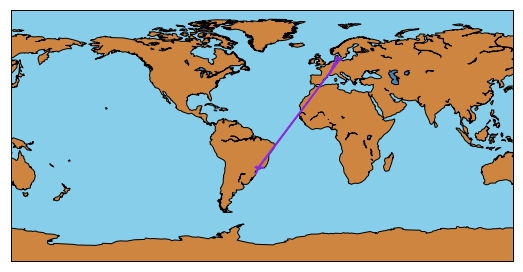

In [173]:
def simple_plot(df):
    fig = plt.figure(figsize=(9,6))

    central_lat = df['latitude'].mean() 
    central_lon = df['longitude'].mean()

    bmap = Basemap(projection='cyl', 
                  lat_0=central_lat, lon_0=central_lon)

    bmap.drawmapboundary(fill_color='SkyBlue')
    bmap.fillcontinents(color='Peru',lake_color='SteelBlue')
    bmap.drawcoastlines()

    x, y = bmap(np.array(df.longitude), np.array(df.latitude))
    bmap.plot(x, y, marker=None, color='BlueViolet')
    
    return fig

fig = simple_plot(df)

This is already a very interesting result. From a few lines of code, one can see all the info that Google has accumulated while I used my phone. It has my day-to-day routine, and a few trips I made to Europe. This map, as is, cannot show too much detail. This can be fixed by, for example, using a different visualization backend, `nbagg`. It requires, however, a `show()` command.

To activate `nbagg`, you can use the *magic* command `%matplotlib nbagg`. [This reference](https://ipython.readthedocs.io/en/stable/interactive/magics.html) has a complete list of the commands available. You can use the left mouse button to scroll through the map, and the right mouse button to zoom.

<IPython.core.display.Javascript object>


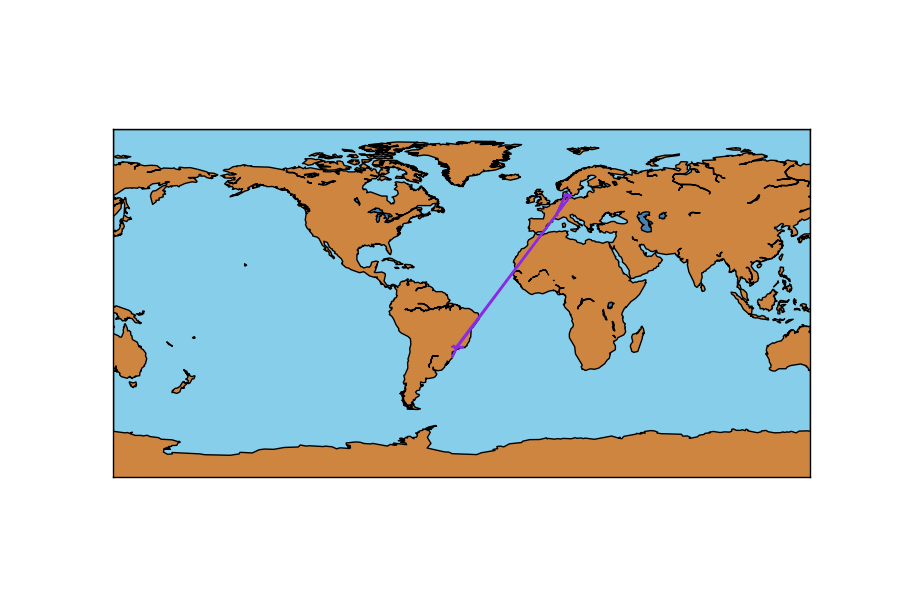

In [177]:
%matplotlib nbagg
_ = simple_plot(df)
#plt.show()

It would be nice to focus on specific areas of the map. I will now create some maps based on specifying the coordinates we wish to focus on. To do that, we can use a few keyword arguments of basemap, which specify the latitudes and longitudes of the *l*ower *l*eft and *u*pper *r*ight ends of the map.

-53.46323


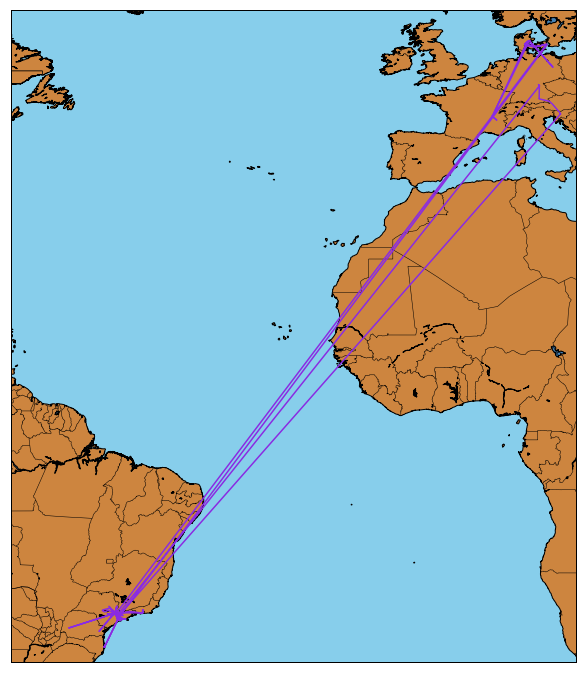

In [211]:
%matplotlib inline

#def buff(num, percentage, direction):
#    if (num <= 0) and (direction == 'up'):
#        return num * (1 + buf)


def focused_plot(df):
    fig = plt.figure(figsize=(12,12))

    minlat = df.latitude.min()
    minlon = df.longitude.min()
    maxlat = df.latitude.max()
    maxlon = df.longitude.max()
    
    buffer_x = 0.15
    buffer_y = buffer_x / 2

    m = Basemap(llcrnrlon=minlon * (1 + buffer_x),  # lower left corner longitude.
                llcrnrlat=minlat * (1 + buffer_y),  # lower left corner latitude
                urcrnrlon=maxlon * (1 + buffer_x),  # upper right corner longitude
                urcrnrlat=maxlat * (1 + buffer_y),  # upper right corner latitude
                projection='cyl',      # map projection type
                resolution='i',        # resolution of the borders. 'i' is for intermediate.
                lat_0 = (minlat + maxlat) / 2,
                lon_0 = (minlon + maxlon) / 2
               )

    m.drawmapboundary(fill_color='SkyBlue')
    m.fillcontinents(color='Peru',lake_color='SteelBlue')
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    x, y = m(np.array(df.longitude), np.array(df.latitude))
    m.plot(x, y, marker=None, color='BlueViolet')
    print(minlon)
    
_ = focused_plot(df)

The buffer values are there to provide some means of not having so much of our data right at the edges of the map. They can be exchanged for raw values also. However, you need to be careful with negative and positive degrees. For example, countries on the southern hemisphere will have negative longitudes and latitudes, so you need to add, or subtract, accordingly.

Interestingly, the map shows that I was at a few locations which I did not visit. For example, I have never been to the state southwest of my own (Paraná), but the data says I was. Also, I never visited Berlin, yet there's another datapoint there. Very weird.

Next, we can observe my routine, but creating a function to show the data around a specific area.

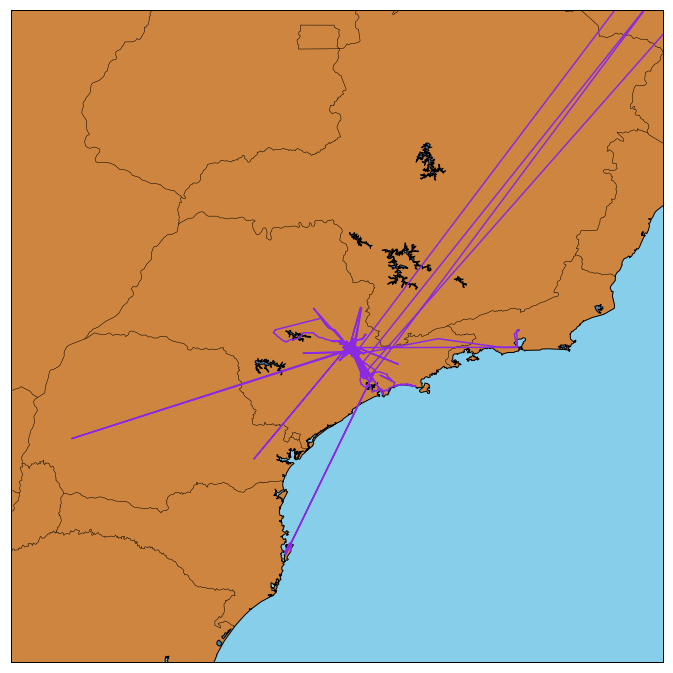

In [212]:
def plot_area(df, lat, lon, llat_buffer, llon_buffer, rlat_buffer, rlon_buffer):
    fig = plt.figure(figsize=(12,12))

    m = Basemap(llcrnrlon=lon + llon_buffer,
                llcrnrlat=lat + llat_buffer,
                urcrnrlon=lon + rlon_buffer,
                urcrnrlat=lat + rlat_buffer,
                projection='cyl',
                resolution='i',
                lat_0=lat,
                lon_0=lon,
               )
   
    m.drawmapboundary(fill_color='SkyBlue')
    m.fillcontinents(color='Peru',lake_color='SteelBlue')
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    x, y = m(np.array(df.longitude), np.array(df.latitude))
    m.plot(x, y, marker=None, color='BlueViolet')
    
_ = plot_area(df, df['latitude'].mean(), df['longitude'].mean(), -10, -10, 5, 5)

And here we can see a beach trip, a Rio trip, a Florianópolis trip, and the most frustrating interview I ever had, in the middle of nowhere. We can use the same function to see my trips to Europe.

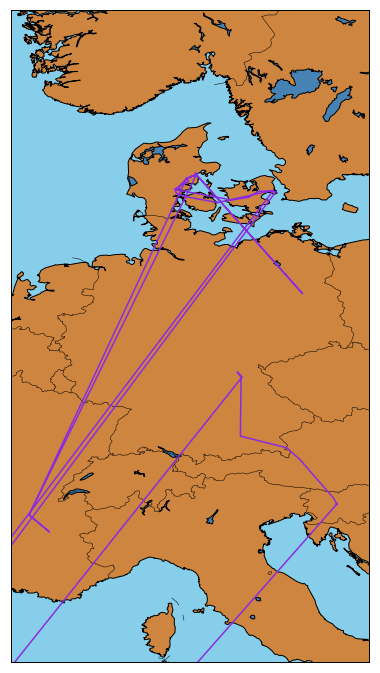

In [213]:
_ = plot_area(df, df['latitude'].max(), df['longitude'].max(), -15, -10, 5, 1)

Well, there are missing spots here. When I went to Ljubljana, I visited Bayreuth in Germany, but I had to go back to Ljubljana, and the data doesn't show that. There's a high probability that I put my phone in airplane mode during the trip back, to save on cellphone battery, so it didn't register.

## Conclusion

I showed how to get your location history from Google, and how you can use a few tools in Python to easily manipulate thousands of datapoints, and plot them relatively easily.

## Getting out the data from the activity column

I had to create my own function to get this to work. I would highly appreciate if someone knows a simpler way to do this

In [214]:
def unwind_activity(activity_column):
    if isinstance(activity_column, list):  # Ignores if it finds NAs or Nones
        t = activity_column[0]['activity'][0]['type']
        confidence = activity_column[0]['activity'][0]['confidence']
        return (t, confidence)
    else:
        return (None, None)

In [216]:
activities = df['activity'].apply(unwind_activity)  # Applies my custom function
# Converts the Series of Tuples into a DataFrame
activities = pd.DataFrame(activities.tolist(), columns = ['activity_type', 'activity_confidence'])
new_df = pd.concat([df, activities], axis=1) # Concatenates both dataframes
new_df.head()

,accuracy,activity,altitude,heading,latitude,longitude,timestampMs,velocity,verticalAccuracy,activity_type,activity_confidence
0,16,"[{'timestampMs': '1552567462890', 'activity': ...",NaN,NaN,-23.070641,-46.949386,1552567402627,NaN,NaN,STILL,100.0
1,31,"[{'timestampMs': '1552567282375', 'activity': ...",NaN,NaN,-23.070648,-46.949136,1552567282246,NaN,NaN,STILL,100.0
2,31,NaN,NaN,NaN,-23.070647,-46.949139,1552567221258,NaN,NaN,None,NaN
3,33,NaN,NaN,NaN,-23.070649,-46.949379,1552567115729,NaN,NaN,None,NaN
4,15,"[{'timestampMs': '1552567099064', 'activity': ...",NaN,NaN,-23.070642,-46.949386,1552567098972,NaN,NaN,STILL,100.0


For curiosity, what are the unique values in the activity type?

In [215]:
pd.unique(activities['activity_type'])

array(['STILL', None, 'TILTING', 'UNKNOWN', 'ON_FOOT', 'IN_VEHICLE',
       'ON_BICYCLE', 'EXITING_VEHICLE'], dtype=object)

Well, I don't know exactly what `TILTING` would mean. I rarely use the bicycle. How can it detect if I'm leaving a vehicle? By a differential in speed? Does `IN_VEHICLE` include airplanes perhaps?